In [133]:
pip install opencv-python opencv-contrib-python matplotlib numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\Hello\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Getting Correspondences

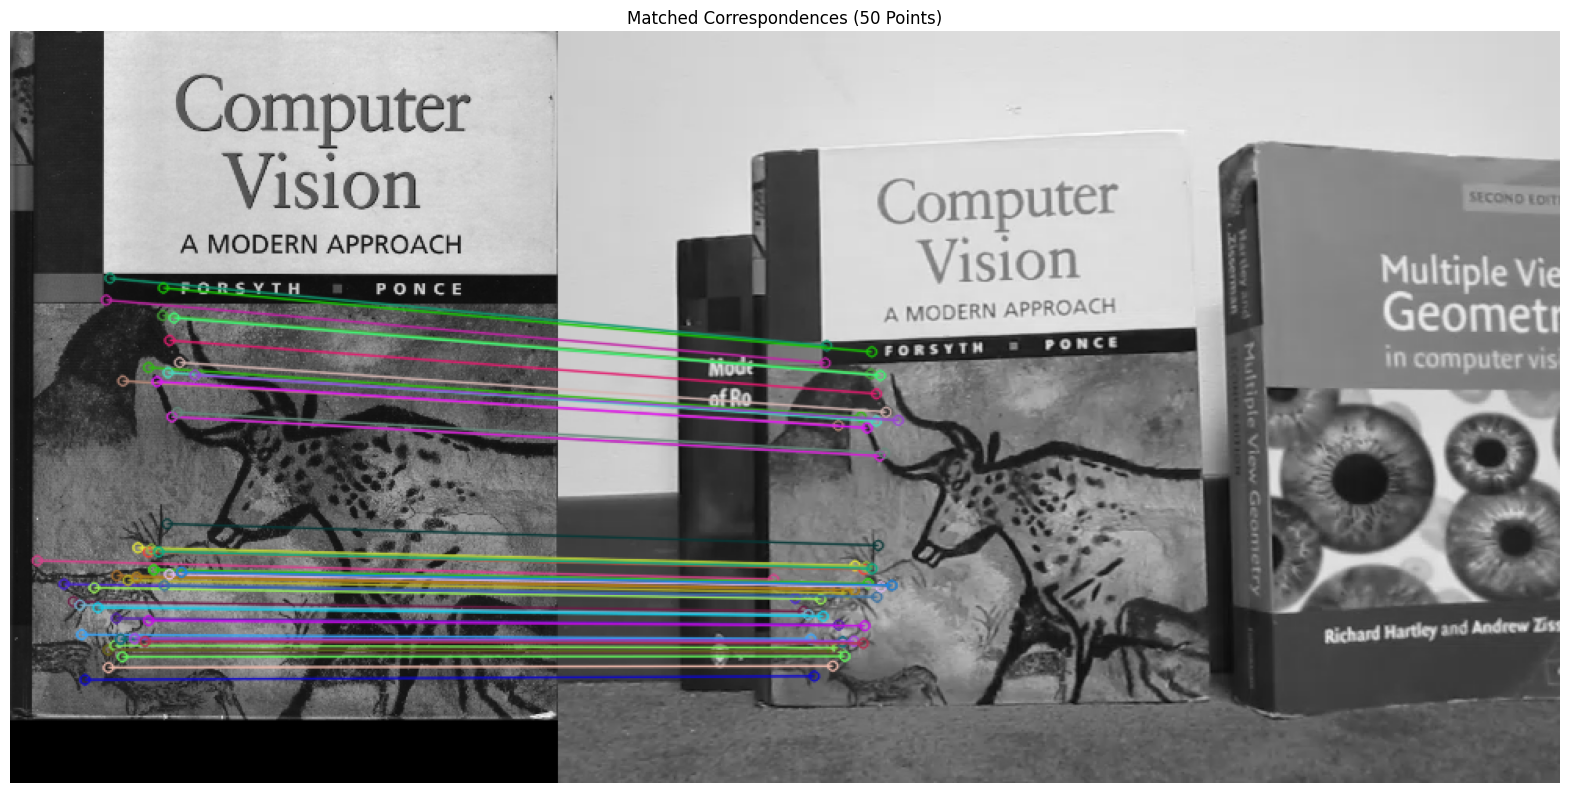

In [134]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the book image
img_book = cv2.imread("cv_cover.jpg")  
img_book = cv2.cvtColor(img_book, cv2.COLOR_BGR2RGB)

# Load the first frame from the video
cap = cv2.VideoCapture("book.mov")  
ret, frame_video = cap.read()
cap.release()
if not ret:
    raise ValueError("Failed to read the first video frame.")
frame_video_rgb = cv2.cvtColor(frame_video, cv2.COLOR_BGR2RGB)

# Convert images to grayscale
gray_book = cv2.cvtColor(img_book, cv2.COLOR_RGB2GRAY)
gray_video = cv2.cvtColor(frame_video_rgb, cv2.COLOR_RGB2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
kp_book, des_book = sift.detectAndCompute(gray_book, None)
kp_video, des_video = sift.detectAndCompute(gray_video, None)

# Brute-Force Matcher with KNN (k=2)
bf = cv2.BFMatcher()
matches = bf.knnMatch(des_book, des_video, k=2)

# Apply ratio test (Lowe's ratio = 0.5)
good_matches = []
for m, n in matches:
    ratio = m.distance / n.distance  # Explicit ratio calculation
    if ratio < 0.5:  # Compare against threshold
        good_matches.append(m)

# Select top 50 matches
selected_matches = good_matches[:50]

# Draw matches
matched_img = cv2.drawMatches(
    img_book, kp_book,
    gray_video, kp_video,
    selected_matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# Display the result
plt.figure(figsize=(20, 10))
plt.imshow(matched_img)
plt.axis('off')
plt.title('Matched Correspondences (50 Points)')
plt.show()

Lowe's Ratio Test is a method introduced by David Lowe in his SIFT paper to filter ambiguous feature matches. It works by comparing the ratio of the distances between the best and second-best matches in the feature descriptor space. A lower ratio number introduces a stricter Filter

Compute the Homography Parameters

In [135]:
import numpy as np

def compute_homography(src_pts, dst_pts):
    assert len(src_pts) >= 4, "At least 4 correspondences are required."
    n = src_pts.shape[0]
    A = []
    
    for i in range(n):
        x, y = src_pts[i]
        xp, yp = dst_pts[i]
        # Equations for x' and y'
        A.append([x, y, 1, 0, 0, 0, -x*xp, -y*xp])
        A.append([0, 0, 0, x, y, 1, -x*yp, -y*yp])
    
    A = np.array(A)
    b = dst_pts.reshape(-1, 1)  # Flatten to (2n, 1)
    
    # Solve Ah = b using least squares
    h, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    h = h.flatten()  # Convert to 1D array
    
    # Build the 3x3 homography matrix (H[2,2] = 1)
    H = np.array([
        [h[0], h[1], h[2]],
        [h[3], h[4], h[5]],
        [h[6], h[7], 1.0]
    ])
    return H

Computes the homography matrix H using Direct Linear Transform (DLT).
    Args:
        src_pts: (n, 2) numpy array of source image points.
        dst_pts: (n, 2) numpy array of destination image points.
    Returns:
        H: (3, 3) homography matrix.

In [136]:
import matplotlib.pyplot as plt

def verify_homography(H, src_pts, dst_pts, img_src, img_dst):
    """
    Projects source points using H and visualizes alignment with destination points.
    """
    # Project source points to destination
    projected_pts = []
    for pt in src_pts:
        p_homo = np.array([pt[0], pt[1], 1.0])
        p_proj = H @ p_homo
        p_proj /= p_proj[2]  # Normalize
        projected_pts.append(p_proj[:2])
    projected_pts = np.array(projected_pts)
    
    # Plot results
    plt.figure(figsize=(15, 7))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_src)
    plt.scatter(src_pts[:, 0], src_pts[:, 1], c='red', s=50, label='Source Points')
    plt.title('Source Image')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_dst)
    plt.scatter(dst_pts[:, 0], dst_pts[:, 1], c='blue', s=50, label='Destination Points')
    plt.scatter(projected_pts[:, 0], projected_pts[:, 1], c='lime', marker='x', s=100, linewidth=2, label='Projected Points')
    plt.title('Destination Image with Projected Points')
    plt.legend()
    plt.show()
    
    # Compute reprojection error
    error = np.mean(np.linalg.norm(projected_pts - dst_pts, axis=1))
    print(f"Reprojection Error (Avg): {error:.2f} pixels")

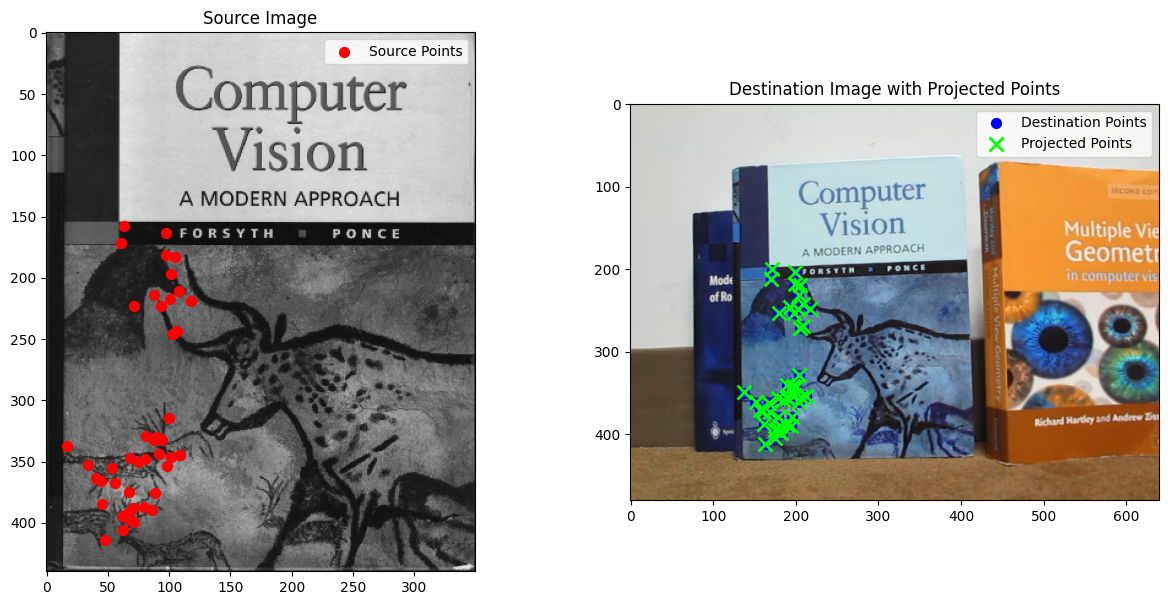

Reprojection Error (Avg): 0.35 pixels


In [137]:
# Compute homography
# Extract coordinates of matched keypoints
src_pts = np.float32([kp_book[m.queryIdx].pt for m in selected_matches]).reshape(-1, 2)
dst_pts = np.float32([kp_video[m.trainIdx].pt for m in selected_matches]).reshape(-1, 2)
H = compute_homography(src_pts, dst_pts)

# Verify alignment
verify_homography(H, src_pts, dst_pts, img_book, frame_video)

Calculate Book Coordinates

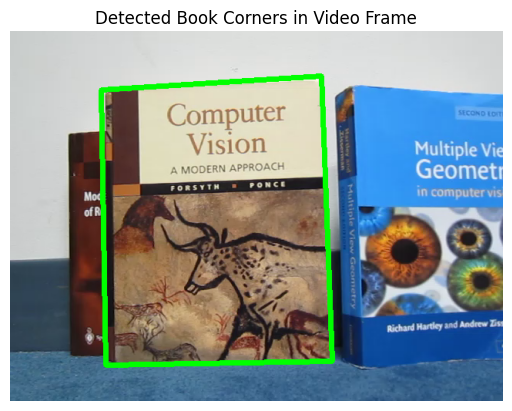

In [138]:
# Step 1: Define book corners
height, width = img_book.shape[:2]
corners_book = np.float32([[0, 0], [width-1, 0], [width-1, height-1], [0, height-1]])

# Step 2: Project corners to video frame
corners_book_reshaped = corners_book.reshape(-1, 1, 2)
corners_video = cv2.perspectiveTransform(corners_book_reshaped, H)
corners_video = corners_video.reshape(-1, 2).astype(int)

# Step 3: Visualize
frame_with_corners = frame_video_rgb.copy()
cv2.polylines(frame_with_corners, [corners_video], isClosed=True, color=(0, 255, 0), thickness=5)
plt.imshow(frame_with_corners)
plt.title('Detected Book Corners in Video Frame')
plt.axis('off')
plt.show()

Crop AR Video Frames

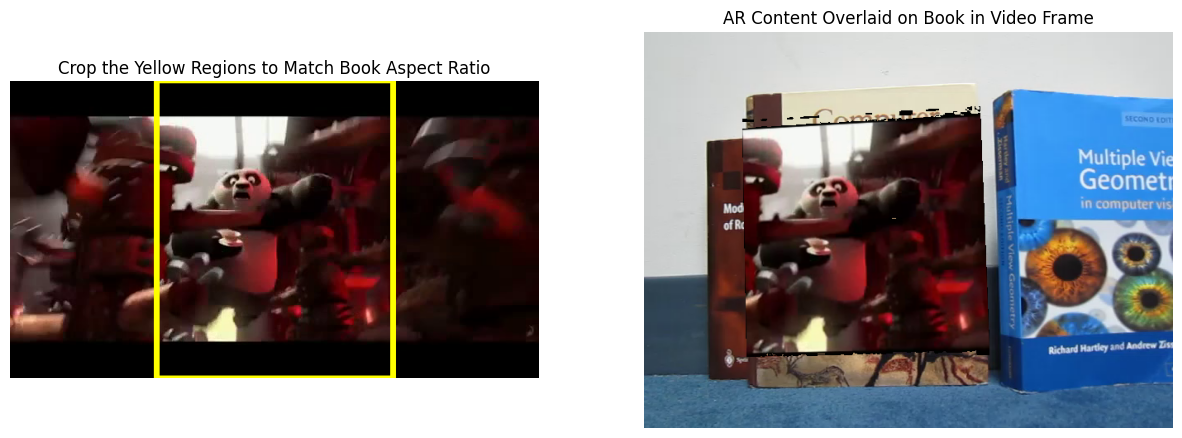

In [142]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 1. Load the original book image
# -------------------------------------------------------
img_book = cv2.cvtColor(cv2.imread('cv_cover.jpg'), cv2.COLOR_BGR2RGB)
height_book, width_book = img_book.shape[:2] 

# Aspect ratio of book (width/height)
target_aspect_ratio = width_book / height_book

# -------------------------------------------------------
# 2. Load AR video and read a specific frame
# -------------------------------------------------------
ar_cap = cv2.VideoCapture('ar_source.mov')
desired_frame = 30*12  

ar_frame = None
for _ in range(desired_frame + 1):
    ret, ar_frame = ar_cap.read()
    if not ret:
        break

# Release capture (only once)
ar_cap.release()

# Convert that AR frame to RGB
ar_frame_rgb = cv2.cvtColor(ar_frame, cv2.COLOR_BGR2RGB)

# Dimensions of the AR frame
ar_height, ar_width = ar_frame_rgb.shape[:2]

# -------------------------------------------------------
# 3. Define function to compute centered crop
# -------------------------------------------------------
def get_crop_box(frame_w, frame_h, target_ar):
   
    frame_ar = frame_w / frame_h

    if target_ar > frame_ar:
        # Width-limited crop => the full width is used, height shrinks
        crop_w = frame_w
        crop_h = int(crop_w / target_ar)
    else:
        # Height-limited crop => the full height is used, width shrinks
        crop_h = frame_h
        crop_w = int(crop_h * target_ar)

    # Center the crop
    x = (frame_w - crop_w) // 2
    y = (frame_h - crop_h) // 2
    return x, y, crop_w, crop_h

# -------------------------------------------------------
# 4. Compute crop box for the AR frame
# -------------------------------------------------------
crop_x, crop_y, crop_w, crop_h = get_crop_box(
    ar_width, ar_height, target_aspect_ratio
)

# Make a copy of the AR frame for drawing the crop box
ar_frame_with_rect = ar_frame_rgb.copy()
cv2.rectangle(
    ar_frame_with_rect,
    (crop_x, crop_y),
    (crop_x + crop_w, crop_y + crop_h),
    (255, 255, 0),  # yellow in RGB
    5
)

# -------------------------------------------------------
# 5. Crop and resize the AR frame to match the book
# -------------------------------------------------------
cropped_ar = ar_frame_rgb[crop_y : crop_y + crop_h, 
                          crop_x : crop_x + crop_w]
cropped_ar_resized = cv2.resize(cropped_ar, (width_book, height_book))

# -------------------------------------------------------
# 6. Load a frame from the book video & convert to RGB
# -------------------------------------------------------
cap = cv2.VideoCapture('book.mov')
ret, frame_video = cap.read()
cap.release()

frame_video_rgb = cv2.cvtColor(frame_video, cv2.COLOR_BGR2RGB)

# -------------------------------------------------------
# 7. Warp the cropped AR frame with homography H
#    
# -------------------------------------------------------

warped_ar = cv2.warpPerspective(
    cropped_ar_resized,
    H,
    (frame_video_rgb.shape[1], frame_video_rgb.shape[0])
)

# -------------------------------------------------------
# 9. Create mask, overlay, and blend
# -------------------------------------------------------
mask = (warped_ar.sum(axis=2) > 0).astype(np.uint8) * 255

overlay = frame_video_rgb.copy()
overlay[mask > 0] = warped_ar[mask > 0]

# -------------------------------------------------------
# 9. Display the final result
# -------------------------------------------------------
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(ar_frame_with_rect)
plt.title('Crop the Yellow Regions to Match Book Aspect Ratio')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title('AR Content Overlaid on Book in Video Frame')
plt.axis('off')

plt.show()


Overlay the First Frame of the Two Videos


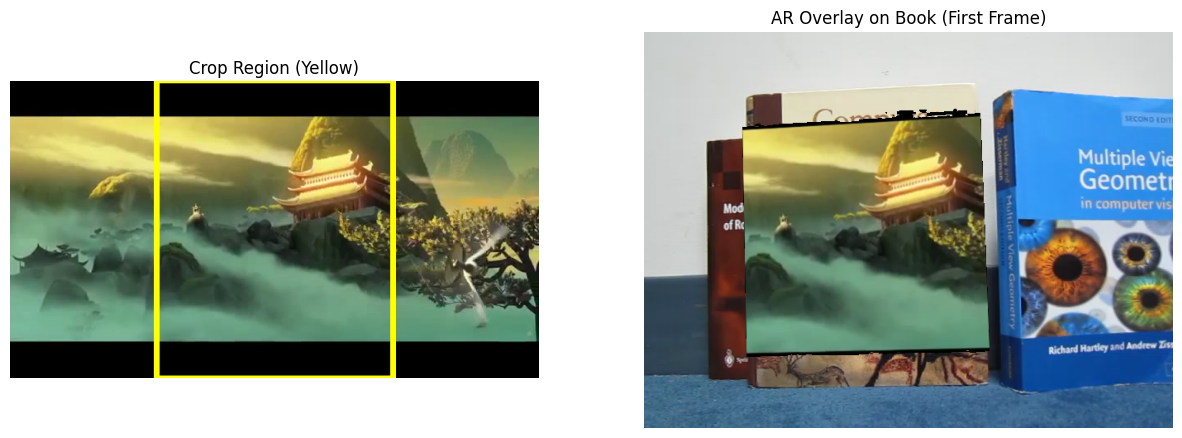

In [144]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 1. Load Data & Precompute Essentials
# -------------------------------------------------------
# Book image and aspect ratio
img_book = cv2.cvtColor(cv2.imread('cv_cover.jpg'), cv2.COLOR_BGR2RGB)
height_book, width_book = img_book.shape[:2]
target_aspect_ratio = width_book / height_book

# Load FIRST FRAME of AR video
ar_cap = cv2.VideoCapture('ar_source.mov')
ret, ar_frame = ar_cap.read()  # First frame (index=0)
ar_cap.release()
ar_frame_rgb = cv2.cvtColor(ar_frame, cv2.COLOR_BGR2RGB)

# -------------------------------------------------------
# 2. Compute Crop Region for AR Frame
# -------------------------------------------------------
def get_crop_box(frame_w, frame_h, target_ar):
    if target_ar > (frame_w / frame_h):
        crop_w, crop_h = frame_w, int(frame_w / target_ar)
    else:
        crop_h, crop_w = frame_h, int(frame_h * target_ar)
    return (frame_w - crop_w)//2, (frame_h - crop_h)//2, crop_w, crop_h

crop_x, crop_y, crop_w, crop_h = get_crop_box(
    ar_frame_rgb.shape[1], ar_frame_rgb.shape[0], target_aspect_ratio
)

# -------------------------------------------------------
# 3. Crop & Resize AR Frame
# -------------------------------------------------------
cropped_ar = ar_frame_rgb[crop_y : crop_y+crop_h, crop_x : crop_x+crop_w]
cropped_ar_resized = cv2.resize(cropped_ar, (width_book, height_book))

# -------------------------------------------------------
# 4. Load FIRST FRAME of Book Video & Compute H (Critical!)
# -------------------------------------------------------
cap = cv2.VideoCapture('book.mov')
ret, frame_video = cap.read()  # First frame (index=0)
cap.release()
frame_video_rgb = cv2.cvtColor(frame_video, cv2.COLOR_BGR2RGB)

# -------------------------------------------------------
# 5. Homography Validation (Add this if missing!)
# -------------------------------------------------------
# Assuming H is precomputed from Part 1.2 (e.g., using SIFT + RANSAC)
# If not, add:
# from compute_homography import compute_homography  # Your function
# H = compute_homography(src_pts, dst_pts)

# -------------------------------------------------------
# 6. Warp & Overlay
# -------------------------------------------------------
warped_ar = cv2.warpPerspective(
    cropped_ar_resized, H, 
    (frame_video_rgb.shape[1], frame_video_rgb.shape[0]))
mask = (warped_ar.sum(axis=2) > 0).astype(np.uint8) * 255
overlay = frame_video_rgb.copy()
overlay[mask > 0] = warped_ar[mask > 0]

# -------------------------------------------------------
# 7. Visualize Results
# -------------------------------------------------------
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(cv2.rectangle(ar_frame_rgb.copy(), 
    (crop_x, crop_y), (crop_x+crop_w, crop_y+crop_h), (255, 255, 0), 5))
plt.title('Crop Region (Yellow)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title('AR Overlay on Book (First Frame)')
plt.axis('off')

plt.show()